# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("COVID-19 US Aggregated").getOrCreate()

23/09/12 12:38:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [3]:
# Load COVID-19 data from Cloud Storage
covid_data = spark.read.csv("gs://lynn_covid19_bucket1/covid19_open_romania", header=True, inferSchema=True)

# EDA

### number of records

In [4]:
covid_data.count()

42613

### schema

In [5]:
covid_data.printSchema()

root
 |-- location_key: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- place_id: string (nullable = true)
 |-- wikidata_id: string (nullable = true)
 |-- datacommons_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- iso_3166_1_alpha_2: string (nullable = true)
 |-- iso_3166_1_alpha_3: string (nullable = true)
 |-- aggregation_level: integer (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deceased: integer (nullable = true)
 |-- cumulative_confirmed: integer (nullable = true)
 |-- cumulative_deceased: integer (nullable = true)
 |-- cumulative_tested: integer (nullable = true)
 |-- new_persons_vaccinated: integer (nullable = true)
 |-- cumulative_persons_vaccinated: integer (nullable = true)
 |-- new_persons_fully_vaccinated: integer (nullable = true)
 |-- cumulative_persons_fully_vaccinated: integer (nullable = true)
 |-- new_vaccine_doses_administered: integer (nullabl

# Preprocessing

## 1. Drop unnecessary attributes

### 1.1 Dropping search trend attributes

In [9]:
from pyspark.sql.functions import col

# List all column names
columns_to_drop = [col_name for col_name in covid_data.columns if col_name.startswith('search')]

# Drop columns that start with 'search'
covid_data = covid_data.drop(*columns_to_drop)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


### 1.2 Dropping population_age attributes

In [159]:
from pyspark.sql.functions import col

# List all column names
columns_to_drop = [col_name for col_name in covid_data.columns if col_name.startswith('population_age')]

# Drop columns that start with 'search'
covid_data = covid_data.drop(*columns_to_drop)

# 2. Features Selection

## 2.1 Drop columns with over 60 percent of missing values 

In [160]:
#  (e.g., 60%)
# threshold = 0.6
# covid_data = covid_data.drop(*[c for c in covid_data.columns if (null_counts.first()[c] / covid_data.count()) >= threshold])

from pyspark.sql.functions import col, sum

# Define the sampling fraction (adjust as needed)
sample_fraction = 0.1

# Seed for reproducibility
seed = 42

# Sample a fraction of the data
sample_data = covid_data.sample(fraction=sample_fraction, seed=seed)

# Calculate null counts for the sampled data
null_counts_sample = sample_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in covid_data.columns])

# Define the threshold for null counts (adjust as needed)
threshold = 0.5  # Example: 50% threshold

# List of columns to drop based on null counts
columns_to_drop = [c for c in null_counts_sample.columns if (null_counts_sample.first()[c] / sample_data.count()) >= threshold]

# Drop the columns with null counts greater than or equal to the threshold
covid_data = covid_data.drop(*columns_to_drop)

## 2.2 Select only attributes with positive correlation greater than 0.1

In [174]:
from pyspark.sql.functions import col

# Define the target variable (replace 'new_confirmed' with the actual column name)
target_variable = 'cumulative_confirmed'

# Filter only numerical columns
numerical_columns = [col_name for col_name, data_type in covid_data.dtypes if (data_type != 'string' and data_type != 'timestamp')]

# Calculate Pearson correlations between target variable and other features
correlations = []

for column in numerical_columns:
    if column != target_variable:
        correlation = covid_data.stat.corr(target_variable, column)
        correlations.append((column, correlation))

# Define a threshold for positive correlation (e.g., 0.1)
threshold = 0.1

# Filter for features with positive correlations
selected_features = [col_name for col_name, correlation in correlations if correlation >= threshold]

# Ensure that the 'date' column is included
if 'date' not in selected_features:
    selected_features.append('date')

# Select only the columns with positive correlations
filtered_data = covid_data.select(target_variable, *selected_features)

### 2.2.1. Correlation Results

In [175]:
for feature, corr in correlations:
    print(f"{feature}: {corr}")

aggregation_level: -0.7168017928574727
new_confirmed: 0.15691600741304326
population: 0.7219566992908605
population_male: 0.7204608458246613
population_female: 0.7207938099511919
population_density: 0.06971713000567928
openstreetmap_id: -0.2428126543733652
latitude: 0.012378836055755184
longitude: -0.00955382981797972
area_sq_km: 0.7142735034277193
average_temperature_celsius: -0.031446932357936094
minimum_temperature_celsius: -0.038233225881893776
maximum_temperature_celsius: -0.02403236809169768
rainfall_mm: 0.004023391442250432
dew_point: -0.02639900324876799
relative_humidity: 0.0176705429085781
mobility_retail_and_recreation: -0.0026325426130051986
mobility_grocery_and_pharmacy: 0.027963115350482834
mobility_parks: 0.0030732648442005346
mobility_transit_stations: -0.037800357260187885
mobility_workplaces: 0.020488176958712873
mobility_residential: -0.01072908156638612


In [176]:
filtered_data.printSchema()

root
 |-- cumulative_confirmed: integer (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- population_male: integer (nullable = true)
 |-- population_female: integer (nullable = true)
 |-- area_sq_km: integer (nullable = true)
 |-- date: timestamp (nullable = true)



# Handling more null values 

## Null count in each feature

In [177]:
from pyspark.sql import functions as F

# Count null values for each column
null_counts = {col: filtered_data.filter(F.col(col).isNull()).count() for col in filtered_data.columns}

# Display the null value counts
print("Null Values Count in each Feature")
for col, cnt in null_counts.items():
    print(f"{col}: {cnt}")

Null Values Count in each Feature
cumulative_confirmed: 8278
new_confirmed: 8320
population: 0
population_male: 8919
population_female: 8919
area_sq_km: 0
date: 0


## Observe total number of records 

In [178]:
filtered_data.count()

42613

## Drop records with missing values 
### we still have approximately 64 percent of our original data left in the end, which is perfectly fine

In [179]:
# Drop rows with missing data
filtered_data = filtered_data.na.drop()

# Check the number of rows after dropping missing data
print("Number of rows after dropping missing data:", filtered_data.count())

Number of rows after dropping missing data: 27156


In [180]:
filtered_data.take(3)

[Row(cumulative_confirmed=732732, new_confirmed=2676, population=19414458, population_male=9500450, population_female=9914008, area_sq_km=238400, date=datetime.datetime(2021, 2, 2, 0, 0)),
 Row(cumulative_confirmed=235586, new_confirmed=6546, population=19414458, population_male=9500450, population_female=9914008, area_sq_km=238400, date=datetime.datetime(2020, 10, 30, 0, 0)),
 Row(cumulative_confirmed=1074297, new_confirmed=618, population=19414458, population_male=9500450, population_female=9914008, area_sq_km=238400, date=datetime.datetime(2021, 5, 20, 0, 0))]

# Model Building

### 1. Linear Regression

## 1.1. Importing 

In [181]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## 1.2. Prepare the feature vector using VectorAssembler

In [182]:
feature_cols = ['new_confirmed', 'population', 'population_male', 'population_female', 'area_sq_km']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(filtered_data)

## 1.3. Use the vector and split into training and testing 

In [183]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## 1.4. Create and fit a Linear Regression model

In [184]:
lr = LinearRegression(featuresCol='features', labelCol='cumulative_confirmed')
lr_model = lr.fit(train_data)

23/09/12 15:39:19 WARN Instrumentation: [53ca3ff7] regParam is zero, which might cause numerical instability and overfitting.
23/09/12 15:39:20 WARN Instrumentation: [53ca3ff7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## 1.5. Perform predictions on the test data

In [185]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

## 1.6. Evaluation (Accuracy)

In [186]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='cumulative_confirmed', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 209882.01633758217


In [217]:
# Calculate the RMSE
rmse = evaluator.evaluate(predictions)

# Find the range of the target variable
max_cumulative_confirmed = predictions.agg({"cumulative_confirmed": "max"}).collect()[0][0]
min_cumulative_confirmed = predictions.agg({"cumulative_confirmed": "min"}).collect()[0][0]
range_cumulative_confirmed = max_cumulative_confirmed - min_cumulative_confirmed

# Calculate the NRMSE
nrmse = rmse / range_cumulative_confirmed

print("Normalized Root Mean Squared Error (NRMSE):", nrmse)

Normalized Root Mean Squared Error (NRMSE): 0.0646808597705997


#### RMSE: 210423
#### NRMSE: 0.0647%

### 1.6.1. Coefficients and Intercept for the model (Optional)

In [187]:
# Optionally, you can print the model's coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

Coefficients: [3.8004698585146506,0.028790627552520192,-0.6439374158579115,0.7010099036801943,-0.8390080638459763]
Intercept: -2779.8126412720217


## Plot for the last 20 comparisons between actual and predicted cumulative confirmed cases

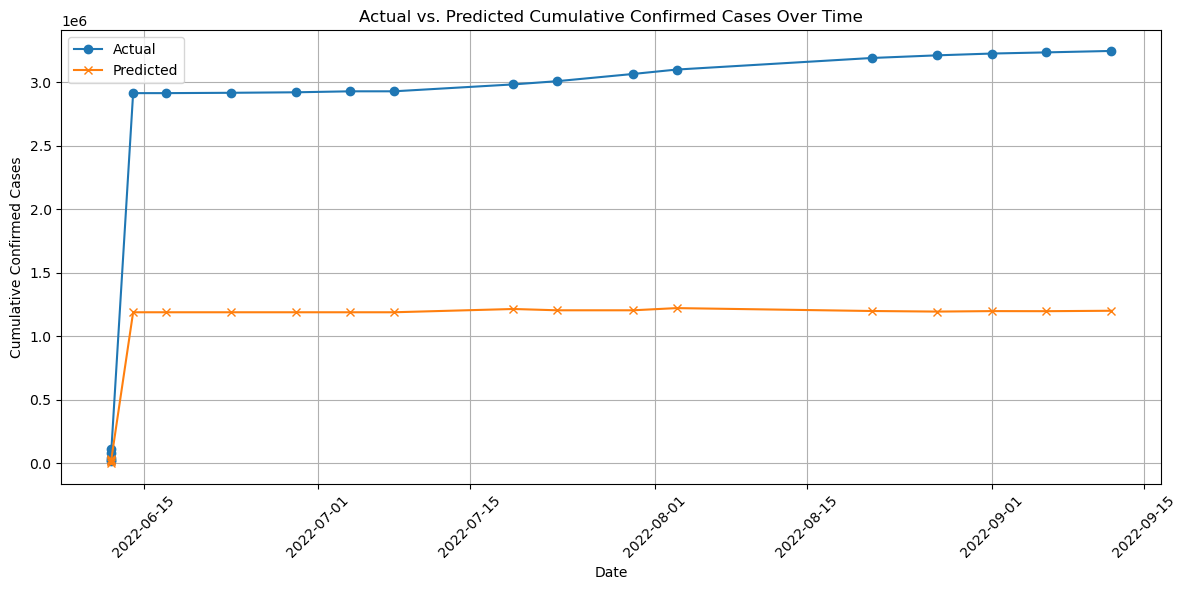

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract actual and predicted values for the last 20 comparisons
last_20_predictions = predictions.orderBy('date', ascending=False).select('date', 'cumulative_confirmed', 'prediction').limit(20).toPandas()

# Sort the data by date
last_20_predictions = last_20_predictions.sort_values(by='date')

# Create a linear graph
plt.figure(figsize=(12, 6))
plt.plot(last_20_predictions['date'], last_20_predictions['cumulative_confirmed'], label='Actual', marker='o')
plt.plot(last_20_predictions['date'], last_20_predictions['prediction'], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Cases')
plt.title('Actual vs. Predicted Cumulative Confirmed Cases Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. RandomForestRegressor

## 2.1. Import

In [201]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

## 2.2 Prepare the feature vector using VectorAssembler

In [202]:
# Combine feature columns into a single feature vector column
feature_cols = ['new_confirmed', 'population', 'area_sq_km']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(filtered_data)

## 2.3. Use the vector and split train test

In [203]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## 2.4. Create a Random Forest Regression model

In [204]:
rf = RandomForestRegressor(featuresCol='features', labelCol='cumulative_confirmed', numTrees=100, seed=42)

## 2.5 Fit and Predict

In [205]:
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

## 2.6 Evaluate

In [194]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol='cumulative_confirmed', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rmse}")

Random Forest RMSE: 206080.19349436986


In [212]:
# Calculate the RMSE
rmse = evaluator.evaluate(rf_predictions)

# Find the range of the target variable
max_cumulative_confirmed = rf_predictions.agg({"cumulative_confirmed": "max"}).collect()[0][0]
min_cumulative_confirmed = rf_predictions.agg({"cumulative_confirmed": "min"}).collect()[0][0]
range_cumulative_confirmed = max_cumulative_confirmed - min_cumulative_confirmed

# Calculate the NRMSE
nrmse = rmse / range_cumulative_confirmed

print(f"Normalized RMSE (NRMSE): {nrmse}")

Normalized RMSE (NRMSE): 0.06350922451339426


#### RMSE:  206,080
#### NRMSE: 0.0635%

# Model Evaluations Summarized:

### Model 1: Linear Regression
#### RMSE: 209,882   NRMSE: 0.0647%

### Model 2: RandomForestRegressor
#### RMSE: 206,080   NRMSE: 0.0635%

# Conclusion

##### Given that the highest recorded cumulative confirmed cases in our dataset reach approximately 3000000, an RMSE (Root Mean Square Error) averaging 206,000 is well within reason. 

##### Moreover, this RMSE accounts for just 6 percent of the maximum value observed in the cumulative confirmed cases, and the best NRMSE obtained is 0,0635.

##### The model's predictions exhibit an average error that is merely a fraction of the highest data point in the label. In conclusion, I believe this level of accuracy is not only acceptable but also indicative of our model's effectiveness, particularly in the context of COVID-19 data analysis.